In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Concatenate, Flatten

# Define function to create the neural network model
def create_nn_model(vocab_size: int, embedding_dim: int, max_length: int, num_of_dense: int, output_dim: int) -> Model:
    """
    Creates a neural network model that processes user prompts using an embedding layer,
    concatenates it with function ratings, and passes through dense layers.

    Args:
        vocab_size (int): Size of the vocabulary for embedding.
        embedding_dim (int): Dimensionality of the embedding layer.
        max_length (int): Maximum length of input sequences.
        num_of_dense (int): Number of dense layers before concatenation.

    Returns:
        Model: A compiled TensorFlow model.
    """
    # Text input (user prompt)
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)(text_input)
    flatten = Flatten()(embedding)

    # Dense layers for text input
    num_neurons = 2**12  # Start with 4096 neurons
    x = flatten
    for _ in range(num_of_dense):
        num_neurons = max(1, int(num_neurons / 2))  # Ensure integer neurons, minimum of 1
        x = Dense(num_neurons, activation='relu')(x)

    # Numeric input (func_rating)
    func_rating_input = Input(shape=(1,), name="func_rating_input")
    y = Dense(32, activation='relu')(func_rating_input)

    # Concatenate both paths
    concatenated = Concatenate()([x, y])
    # output = Dense(1, activation='linear', name="output")(concatenated)
    output = Dense(output_dim, activation='softmax', name="output")(concatenated)

    # Define and compile the model
    model = Model(inputs=[text_input, func_rating_input], outputs=output)

    # Set up learning rate scheduler
    # code here:

    # Compile
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
from repo_extractor import result_df

df = result_df

In [ ]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [ ]:
df.shape

(322, 4)

In [ ]:
# Tokenize and prepare data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df["user_prompt"])
vocab_size = len(tokenizer.word_index) + 1  # Calculates the size of the vocabulary

# Ensuring the vocab_size is large enough for all indices
max_index = max([max(seq) if seq else 0 for seq in tokenizer.texts_to_sequences(df["user_prompt"])])
if max_index >= vocab_size:
    vocab_size = max_index + 1

print(f"Adjusted vocab_size: {vocab_size}")

# Determine the maximum length of sequences
max_length = max([len(x.split()) for x in df["user_prompt"]])
embedding_dim = 8  # You can adjust this dimension based on your model complexity and dataset

# Convert text data into sequences
X_text = tokenizer.texts_to_sequences(df["user_prompt"])
X_text = pad_sequences(X_text, maxlen=max_length, padding='post')
print(X_text.shape)  # This will print the shape of your padded sequence array

# Numeric input
X_func_rating = np.array(df["func_rating"]).reshape(-1, 1)
print(X_func_rating.shape)  # This will print the shape of your function rating array

# Target variable
y = np.array(df["custom_rating"]).reshape(-1, 1)
print(y.shape)  # This will print the shape of your target variable array

Adjusted vocab_size: 908
(322, 26)
(322, 1)
(322, 1)


In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare data for BERT
def prepare_data(texts):
    """
    Prepares input text data into tokenized tensors for BERT.

    Args:
    texts (pd.Series): A pandas series containing text entries.

    Returns:
    tf.Tensor: Tokenized and formatted input for BERT.
    """
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=512, # Can adjust depending on your specific needs
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

# Example usage
X_text, X_mask = prepare_data(df["user_prompt"])

print(X_text.shape)  # This will show the shape of your input_ids
print(X_mask.shape)  # This will show the shape of your attention masks

(322, 512)
(322, 512)


In [ ]:
print(X_mask)

tf.Tensor(
[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]], shape=(322, 512), dtype=int32)


In [ ]:
df["custom_rating"].unique()

array([3, 4, 2, 5, 1, 0])

In [ ]:
from keras.utils import to_categorical

# Assuming y is your array of class labels shaped as (20, 1)
# Convert labels to one-hot encoding
y_one_hot = to_categorical(y > 3)

# Check the new shape of y_one_hot
print(y_one_hot.shape)

(322, 2)


In [ ]:
# Create the model
num_of_dense_layers = 2  # Example: 2 dense layers before concatenation
model = create_nn_model(vocab_size, embedding_dim, max_length, num_of_dense_layers, 2)

/opt/anaconda3/envs/searchbot-001/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Example of setting parameters based on your dataset
vocab_size = len(tokenizer.vocab)  # Using the BERT tokenizer's vocabulary size
print(f"vocab_size: {vocab_size}")
embedding_dim = 100  # Example dimensionality
max_length = 512  # From your output, each input sequence length
num_of_dense = 10  # Example of using three dense layers
output_dim = 2  # Number of output classes, change this as per your specific task

# Initialize the model with the parameters
model = create_nn_model(vocab_size=vocab_size, embedding_dim=embedding_dim, max_length=max_length, num_of_dense=num_of_dense, output_dim=output_dim)

vocab_size: 30522


/opt/anaconda3/envs/searchbot-001/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
%%time

# Train the model
model.fit(
    {"text_input": X_text, "func_rating_input": X_func_rating},
    y_one_hot,
    epochs=2000,
    batch_size=5,
    validation_split=0.05,
    verbose=2
)

Epoch 1/2000
61/61 - 9s - 146ms/step - accuracy: 0.7770 - loss: 0.4845 - val_accuracy: 0.8824 - val_loss: 0.5048
Epoch 2/2000
61/61 - 9s - 146ms/step - accuracy: 0.7803 - loss: 0.4831 - val_accuracy: 0.8824 - val_loss: 0.4952
Epoch 3/2000
61/61 - 9s - 145ms/step - accuracy: 0.7770 - loss: 0.4839 - val_accuracy: 0.8824 - val_loss: 0.5024
Epoch 4/2000
61/61 - 9s - 145ms/step - accuracy: 0.7639 - loss: 0.4853 - val_accuracy: 0.8824 - val_loss: 0.4967
Epoch 5/2000
61/61 - 9s - 145ms/step - accuracy: 0.7803 - loss: 0.4846 - val_accuracy: 0.8824 - val_loss: 0.5172
Epoch 6/2000
61/61 - 9s - 146ms/step - accuracy: 0.7803 - loss: 0.4849 - val_accuracy: 0.8824 - val_loss: 0.5427
Epoch 7/2000
61/61 - 9s - 146ms/step - accuracy: 0.7803 - loss: 0.4857 - val_accuracy: 0.8824 - val_loss: 0.5119
Epoch 8/2000
61/61 - 9s - 145ms/step - accuracy: 0.7803 - loss: 0.4862 - val_accuracy: 0.8824 - val_loss: 0.4965
Epoch 9/2000
61/61 - 9s - 146ms/step - accuracy: 0.7672 - loss: 0.4863 - val_accuracy: 0.8824 - 

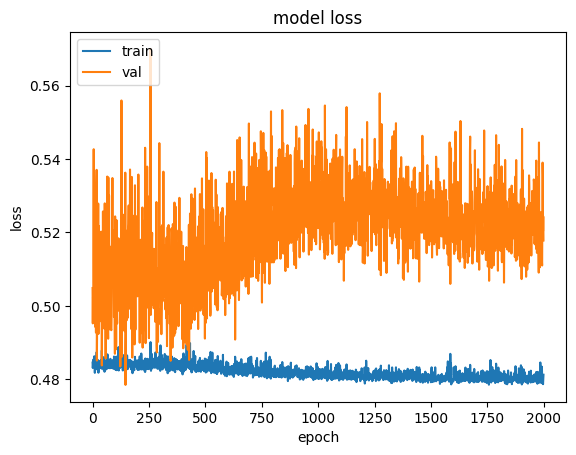

In [ ]:
# Plot error
import matplotlib.pyplot as plt

plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Display the model summary
model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 512, 100)  │  3,052,200 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 51200)     │          0 │ embedding_20[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 2048)      │ 104,859,6… │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 1024)      │  2,098,176 │ dense_124[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 512)       │    524,800 │ dense_125[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_127 (Dense)   │ (None, 256)       │    131,328 │ dense_126[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │     32,896 │ dense_127[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_129 (Dense)   │ (None, 64)        │      8,256 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 32)        │      2,080 │ dense_129[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 16)        │        528 │ dense_130[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 8)         │        136 │ dense_131[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ func_rating_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 4)         │         36 │ dense_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 32)        │         64 │ func_rating_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 36)        │          0 │ dense_133[0][0],  │
│ (Concatenate)       │                   │            │ dense_134[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │         74 │ concatenate_20[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,130,668 (1.24 GB)

 Trainable params: 110,710,222 (422.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 221,420,446 (844.65 MB)

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Predict probabilities for the test set
# Assume X_test_text and X_test_func_rating are your test datasets prepared similarly to your training datasets
predictions = model.predict({"text_input": X_text, "func_rating_input": X_func_rating})

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Since y_test is in one-hot encoded format, convert it back to class labels for evaluation
true_classes = np.argmax(y_one_hot, axis=1)

# Generate a classification report
report = classification_report(true_classes, predicted_classes)
print(report)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
              precision    recall  f1-score   support

           0       0.80      0.94      0.87       236
           1       0.70      0.35      0.47        86

    accuracy                           0.79       322
   macro avg       0.75      0.65      0.67       322
weighted avg       0.77      0.79      0.76       322



In [ ]:
67/(215+67)

0.2375886524822695

In [1]:
from huggingface_hub import HfApi

hf_username = "Bhairavee37"  # Replace with your Hugging Face username
repo_name = "my-tf-nn-model-v2"  # Change this as needed
repo_id = f"{hf_username}/{repo_name}"

api = HfApi()

# Create the repository
api.create_repo(repo_id=repo_id, exist_ok=True)  # exist_ok=True prevents errors if the repo already exists

print(f"Repository created: https://huggingface.co/{repo_id}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


HfHubHTTPError: 401 Client Error: Unauthorized for url: https://huggingface.co/api/repos/create (Request ID: Root=1-67c7850b-6869574b62ceee83093bcfcd;e5289f08-02d6-4b76-9da9-1c3bd67d4605)

Invalid username or password.

In [2]:
import pickle
import os
from huggingface_hub import HfApi
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

# Define save directory
model_dir = "./saved_model"
os.makedirs(model_dir, exist_ok=True)

# Save the model
model_path = os.path.join(model_dir, "model.keras")
model.save(model_path)

# Save the tokenizer as a pickle file
tokenizer_path = os.path.join(model_dir, "tokenizer.pkl")
with open(tokenizer_path, "wb") as f:
    pickle.dump(tokenizer, f)

# Upload model and tokenizer to Hugging Face
repo_id = f"{hf_username}/{repo_name}"  # Change as needed
api = HfApi()

api.upload_file(path_or_fileobj=model_path, path_in_repo="model.keras", repo_id=repo_id)
api.upload_file(path_or_fileobj=tokenizer_path, path_in_repo="tokenizer.pkl", repo_id=repo_id)

print(f"Model and tokenizer successfully pushed to: https://huggingface.co/{repo_id}")

NameError: name 'model' is not defined

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from huggingface_hub import hf_hub_download

# Set Keras backend to JAX (Optional, only needed if you want to experiment with JAX backend)
os.environ["KERAS_BACKEND"] = "jax"

# Define repo ID and model filename
# repo_id = "eagle0504/my-tf-nn-model" # we already defined it above
filename = "model.keras"  # Ensure this matches what was uploaded

# Download the model
model_path = hf_hub_download(repo_id=repo_id, filename=filename)

# Load the Keras model
new_model = keras.models.load_model(model_path)

print("Model loaded successfully!")

model.keras:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Model loaded successfully!


In [ ]:
new_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 512)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 512, 100)  │  3,052,200 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 51200)     │          0 │ embedding_20[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_124 (Dense)   │ (None, 2048)      │ 104,859,6… │ flatten_20[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_125 (Dense)   │ (None, 1024)      │  2,098,176 │ dense_124[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_126 (Dense)   │ (None, 512)       │    524,800 │ dense_125[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_127 (Dense)   │ (None, 256)       │    131,328 │ dense_126[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_128 (Dense)   │ (None, 128)       │     32,896 │ dense_127[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_129 (Dense)   │ (None, 64)        │      8,256 │ dense_128[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_130 (Dense)   │ (None, 32)        │      2,080 │ dense_129[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_131 (Dense)   │ (None, 16)        │        528 │ dense_130[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_132 (Dense)   │ (None, 8)         │        136 │ dense_131[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ func_rating_input   │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_133 (Dense)   │ (None, 4)         │         36 │ dense_132[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_134 (Dense)   │ (None, 32)        │         64 │ func_rating_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_20      │ (None, 36)        │          0 │ dense_133[0][0],  │
│ (Concatenate)       │                   │            │ dense_134[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 2)         │         74 │ concatenate_20[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 332,130,668 (1.24 GB)

 Trainable params: 110,710,222 (422.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 221,420,446 (844.65 MB)

In [ ]:
import pickle
from huggingface_hub import hf_hub_download
from tensorflow import keras
import numpy as np
from transformers import BertTokenizer

# Define repo details
repo_id = f"{hf_username}/{repo_name}"

# Download model
model_path = hf_hub_download(repo_id=repo_id, filename="model.keras")
new_model = keras.models.load_model(model_path)

# Load a transformer-based tokenizer (e.g., BertTokenizer)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

print("Model and tokenizer loaded successfully!")

# Sample test data
test_texts = [
    "How to improve focus and concentration?",
    "What are the side effects of lack of sleep?",
]

# Preprocess test data using the Hugging Face tokenizer
max_length = new_model.input_shape[0][1]  # Get max_length from model input shape
X_text_test = tokenizer(
    test_texts,
    max_length=max_length,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

# Dummy numeric input (func_rating)
X_func_test = np.array([5, 4]).reshape(-1, 1)

# Make predictions
predictions = new_model.predict({"text_input": X_text_test["input_ids"], "func_rating_input": X_func_test})

# Display results
for i, text in enumerate(test_texts):
    print(f"Prompt: {text}")
    print(f"Predicted Rating: {predictions[i][0]:.2f}")
    print("-" * 50)

model.keras:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Model and tokenizer loaded successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Prompt: How to improve focus and concentration?
Predicted Rating: 0.29
--------------------------------------------------
Prompt: What are the side effects of lack of sleep?
Predicted Rating: 0.40
--------------------------------------------------
